# Data Collection and EDA

The goal of this workbook is to use APIs to get the following for any ticker:
- Daily open, high, low, close, adjusted close, volume, dividend amount, and split coefficient
- Google trends score

Over the period 01.02.18-06.1.21

Step One: Create a DataFrame for an example ticker. In this case I will use IBM.

Step Two: Generalize the code used for IBM into a function that can be used for any ticker. That function will be named create_ticker_df

Step Three: EDA. Make sure that the APIs are collecting the correct data by verifying against another source.

In [1]:
# Imports
from alpha_vantage.timeseries import TimeSeries
import requests
import pandas as pd
import pandas as pd                        
from pytrends.request import TrendReq
from IPython.display import Image
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf

## Step One: Create a DataFrame for an example ticker. In this case I will use IBM.

### Collecting Stock Data Using Alpha Vantage

In [2]:
key = '49KFJCFS3P6CEU4F'

In [3]:
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=IBM&apikey=49KFJCFS3P6CEU4F&outputsize=full'
r = requests.get(url)
data = r.json()

print(data['Time Series (Daily)']['2021-06-01'])
print(data['Time Series (Daily)']['2018-01-02'])

{'1. open': '145.0', '2. high': '145.83', '3. low': '143.75', '4. close': '144.19', '5. adjusted close': '144.19', '6. volume': '2417455', '7. dividend amount': '0.0000', '8. split coefficient': '1.0'}
{'1. open': '154.5', '2. high': '154.81', '3. low': '153.54', '4. close': '154.25', '5. adjusted close': '130.577642951', '6. volume': '4195225', '7. dividend amount': '0.0000', '8. split coefficient': '1.0'}


The alpha vantage api is able to get the data for the time frame we want. The next step is to translate the JSON into a DataFrame and filter for the date range that I want.

In [4]:
ibm = pd.DataFrame(data['Time Series (Daily)']).T

In [5]:
ibm['date'] = ibm.index

In [6]:
ibm.index = pd.to_datetime(ibm['date'])

In [7]:
ibm = ibm[ibm['date'] > '2018-01-01']
ibm = ibm[ibm['date'] < '2021-06-02']
ibm.drop(columns = 'date', inplace = True)

ibm.sort_index(inplace=True)

In [8]:
ibm.shape

(859, 8)

Now our dataframe is the correct date range. Now it is time to fix the data types and add a column for the daily lag and percent change

In [9]:
ibm['daily_lag'] =  ibm['5. adjusted close'].shift(1)
ibm.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,daily_lag
date,,,,,,,,,
2018-01-02,154.5,154.81,153.54,154.25,130.577642951,4195225,0.0000,1.0,NaN
2018-01-03,157.34,159.81,156.33,158.49,134.166940883,9439063,0.0000,1.0,130.577642951
2018-01-04,159.65,162.32,159.37,161.7,136.884310309,7363843,0.0000,1.0,134.166940883
2018-01-05,162.44,162.9,161.1,162.49,137.553071008,5162075,0.0000,1.0,136.884310309
2018-01-08,162.66,163.91,161.7,163.47,138.382672889,5101023,0.0000,1.0,137.553071008


In [10]:
for col in ibm.columns:
    ibm[col] = pd.to_numeric(ibm[col])

In [11]:
ibm['daily_returns'] = ibm['5. adjusted close'] - ibm['daily_lag']
ibm['daily_pct_return'] = ibm['daily_returns']/ibm['5. adjusted close'].shift(1)
ibm['rolling_3d_adj_close'] = ibm['5. adjusted close'].rolling(3).mean()

ibm.drop(columns = 'daily_lag', inplace = True)

To help account for the effect of covid on the stock market as a whole, we will add a column to our dataset that is the adjusted close of the SPDR S&P 500 ETF. It is the largest ETF in the world and tracks the S&P 500, making it a good proxy for the performance of the market overall

In [12]:
def spdr_adj_close():
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=spy&apikey=49KFJCFS3P6CEU4F&outputsize=full'
    r = requests.get(url)
    data = r.json()
    df = pd.DataFrame(data['Time Series (Daily)']).T
    df['date'] = df.index
    df.index = pd.to_datetime(df['date'])
    df = df[df['date'] > '2018-01-01']
    df = df[df['date'] < '2021-06-02']
    df.drop(columns = 'date', inplace = True)
    df.sort_index(inplace=True)
    return df['5. adjusted close']

## Collecting Trends Data Using Google Trends API

In [13]:
pytrend = TrendReq()
pytrend.build_payload(kw_list=['IBM'])
# Interest by Region
df = pytrend.interest_over_time()
df.tail(10)

,IBM,isPartial
date,,
2021-05-09,50,False
2021-05-16,48,False
2021-05-23,50,False
2021-05-30,49,False
2021-06-06,50,False
2021-06-13,50,False
2021-06-20,50,False
2021-06-27,50,False
2021-07-04,46,False


In [14]:
#google trends only reports data by the week. Since the dataframe we want has a daily index, we will fill out the days based on the trend score at the beginning of that week.
trends = df['IBM'].resample('D', convention = 'start').pad()

trends = pd.DataFrame(trends)
trends.rename(columns = {'IBM':'trend_score'}, inplace = True)
trends.head(3)

,trend_score
date,
2016-07-24,77
2016-07-25,77
2016-07-26,77


Now we have the trends data on a daily index. The next step is to merge the stock data with the trends data. We will do a left merge such that we keep only the days where we have stock data (ie trading days after IPO)

In [15]:
ibm = ibm.merge(trends, how = 'left', left_index = True, right_index = True)

## Create a function to collect the data and create a dataframe for any ticker

The below function is the same code I used for IBM but generalized so the function can be used for any ticker

In [16]:
#create function from the code above that can be used for any ticker
def create_ticker_df (ticker):
    '''Returns a DataFrame of stock and Google Trends data for the given ticker. The output will be daily data 1/2/18-6/1/21'''
    #collect stock data using Alpha Vantage API
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={ticker}&apikey=49KFJCFS3P6CEU4F&outputsize=full'
    r = requests.get(url)
    data = r.json()
    df = pd.DataFrame(data['Time Series (Daily)']).T
    
    #filter to include 2018.01.02 - 2021.06.01
    df['date'] = df.index
    df.index = pd.to_datetime(df['date'])
    df = df[df['date'] > '2018-01-01']
    df = df[df['date'] < '2021-06-02']
    df.drop(columns = 'date', inplace = True)
    df.sort_index(inplace=True)
    
    #add lag columns
    days_to_lag = [1,2,3,7,30,90,365]
    for day in days_to_lag:
        df[f'lag_{day}'] = df['5. adjusted close'].shift(day)
    
    #fix dtypes and column names
    df['spdr_adj_close'] = spdr_adj_close()
   
    
    for col in df.columns:
        df[col] = pd.to_numeric(df[col])
    df['daily_returns'] = df['5. adjusted close'] - df['lag_1']
    df['daily_pct_return'] = df['daily_returns']/df['5. adjusted close'].shift(1)
    df['rolling_3d_adj_close'] = df['5. adjusted close'].rolling(3).mean()
    df.rename(columns = {'1. open': 'open',
                        '2. high': 'high',
                        '3. low': 'low',
                        '4. close': 'close',
                        '5. adjusted close': 'adjusted_close',
                        '6. volume': 'volume',
                        '7. dividend amount': 'dividend amount',
                        '8. split coefficient': 'splitcoef',
                        'daily_returns' : 'daily_returns'}, inplace = True)
        
    #Collect Google Trends data using pytrends api
    pytrend = TrendReq()
    pytrend.build_payload(kw_list=[ticker])
    google = pytrend.interest_over_time()
    trends = google[ticker].resample('D', convention = 'start').pad()
    trends = pd.DataFrame(trends)
    trends.rename(columns = {ticker:'trend_score'}, inplace = True)
    
    #merge stock data with trends data
    df = df.merge(trends, how = 'left', left_index = True, right_index = True)
    
    return df

Test create_ticker_df on Apple:

In [17]:
aapl = create_ticker_df('aapl')
aapl.head()

,open,high,low,close,adjusted_close,volume,dividend amount,splitcoef,lag_1,lag_2,lag_3,lag_7,lag_30,lag_90,lag_365,spdr_adj_close,daily_returns,daily_pct_return,rolling_3d_adj_close,trend_score
date,,,,,,,,,,,,,,,,,,,,
2018-01-02,170.16,172.30,169.26,172.26,41.308268,25048048,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.328547,NaN,NaN,NaN,18
2018-01-03,172.53,174.55,171.96,172.23,41.301074,28819653,0.0,1.0,41.308268,NaN,NaN,NaN,NaN,NaN,NaN,253.924553,-0.007194,-0.000174,NaN,18
2018-01-04,172.54,173.47,172.08,173.03,41.492916,22211345,0.0,1.0,41.301074,41.308268,NaN,NaN,NaN,NaN,NaN,254.994815,0.191841,0.004645,41.367419,18
2018-01-05,173.44,175.37,173.05,175.00,41.965325,23016177,0.0,1.0,41.492916,41.301074,41.308268,NaN,NaN,NaN,NaN,256.694092,0.472410,0.011385,41.586438,18
2018-01-08,174.35,175.61,173.93,174.35,41.809454,20134092,0.0,1.0,41.965325,41.492916,41.301074,NaN,NaN,NaN,NaN,257.163506,-0.155871,-0.003714,41.755898,18


# EDA: Checking create_ticker_df for Accuracy

### Validating Alpha Vantage Data Against Another Source (Yahoo Finance)

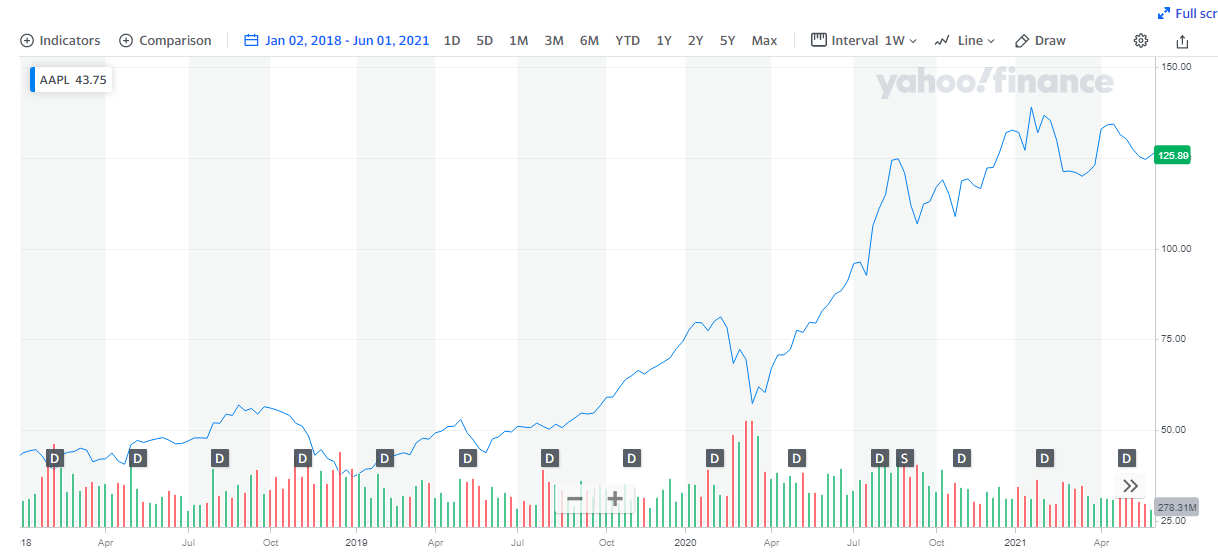

In [18]:
Image('./Pictures/AAPL Snip.png', width=700)

Above is the stock price chart for AAPL 1.2.18-6.1.21 per Yahoo Finance. Below is the chart of our closing prices for that same time period.

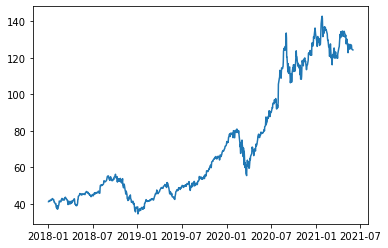

In [19]:
plt.plot(aapl['adjusted_close']);

Are these two graphs the same? One way to validate is to compare the Alpha Vantage adjusted closing prices against AAPL.csv, which I downloaded from Yahoo Finance at https://finance.yahoo.com/quote/AAPL/history/

In [20]:
yf = pd.read_csv('./Data/AAPL.csv')

In [21]:
yf.index = pd.to_datetime(yf['Date'])
yf = yf[yf['Date'] > '2018-01-01']
yf = yf[yf['Date'] < '2021-06-02']
yf.sort_index(inplace=True)

In [22]:
yf.rename(columns = {'Open': 'yf_open',
                     'High': 'yf_high',
                     'Low': 'yf_low',
                     'Close': 'yf_close',
                     'Adj Close': 'yf_adj_close',
                     'Volume': 'yf_volume'}, inplace = True)

In [23]:
yf.head(1)

,Date,yf_open,yf_high,yf_low,yf_close,yf_adj_close,yf_volume
Date,,,,,,,
2020-07-13,2020-07-13,97.264999,99.955002,95.2575,95.477501,94.83847,191649200


The Yahoo Finance download only goes as far back as 2020-07-13, which is why I used Alpha Vantage to get my data in the first place. As a validation tool, however, if the yahoo finance data matches Alpha Vantage for the period 7/13/20-6/1/21, it's fair to say that Alpha Vantage has the correct adjusted closing prices.

In [24]:
yf = yf.merge(aapl, how = 'left', left_index = True, right_index = True)

In [25]:
variance_df = pd.DataFrame()
variance_df['adj_close_diff'] = yf['adjusted_close'] - yf['yf_adj_close']
variance_df.describe()

,adj_close_diff
count,224.000000
mean,0.000130
std,0.001438
min,-0.004703
25%,0.000267
50%,0.000509
75%,0.001081
max,0.001232


The variance between Alpha Vantage and Yahoo Finance's adjusted close amounts is less than a cent per day. For our purposes that's immaterial.

### Validating PyTrends Data Against a Download Directly From the Google Trends Website

Google Trends' scores are subjective based on the time period searched. The data will be scaled such that the hightest search popularity during the selected time period will be 100. As of today (7/13/21), pytrends returns data for the period 7/17/16-7/4/21. Inputting that time period for the search term 'aapl' and downloading the results from Google Trends should match my PyTrends data exactly.

In [26]:
gt_download = pd.read_csv('./Data/google_trends_dowload_aapl.csv')

In [27]:
gt_download.index = pd.to_datetime(gt_download['Week'])
gt_download.sort_index(inplace=True)
gt_download = gt_download.resample('D', convention = 'start').pad()

In [28]:
gt_variance = pd.DataFrame()
gt_variance['trend_score'] = aapl['trend_score']
gt_variance = gt_variance.merge(gt_download, how = 'left', left_index = True, right_index = True)
gt_variance['difference'] = gt_variance['trend_score'] - gt_variance['aapl']
gt_variance['difference'].describe()

count    859.000000
mean      -0.672875
std        1.611106
min       -7.000000
25%       -2.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: difference, dtype: float64

The difference between PyTrends and the download directly from Google Trends is about .36 points/day. Pytrends is never off by more than 5 points on a day.

My guess is that the difference between the two sources is due to when the searches are performed. These scores are subjective based on the time period searched.

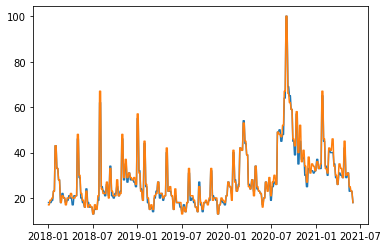

In [29]:
plt.plot(gt_variance[['trend_score', 'aapl']]);

As we can see in the above graph the trend_score from my create_ticker_df and the direct download are very closely overlayed. So for our purposes PyTrends is accurate enough and the difference is immaterial.

Another observation from the above graph is that the search interest in aapl is cyclical. This makes sense as Apple releases products and financial statements periodically which would increase search interest. In our modeling we could account for this seasonality.

### Other EDA to check that create_ticker_df data is accurate

<AxesSubplot:>

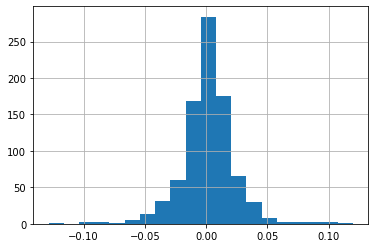

In [30]:
aapl['daily_pct_return'].hist(bins = 20)

The histogram of daily returns is normally shaped with a few outliers. This fits our expectations about the behavior of Apple's stock price

In [31]:
mean_return = aapl['daily_pct_return'].mean()
mean_return

0.0015205344430411372

A mean return close to zero is fitting with our expectations

In [32]:
std_return = aapl['daily_pct_return'].std()
std_return

0.021715717046206954

A low standard deviation is fitting with our expecations because it means that most days there will not be a large swing in the stock price

In [33]:
aapl['daily_pct_return'].kurtosis()

5.391441242809365

A kurtosis value well above 1 means that the tail of the distribution is a small amount of the dataset. This fits our expectations because it is another indicator that days with large price swings are rare

### Checking for seasonality, autocorrelation

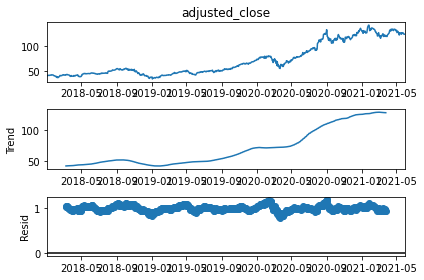

In [34]:
# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(aapl['adjusted_close'], period = 90, model = 'multiplicative')

# Plot the decomposed time series.
decomp.plot(seasonal= False);

We already have lag columns set up for 1,2,3,7,30,90, and 365 days. We can use statsmodels to view the PACF plot for the lags 30 and below. Looking at the time series graph of AAPL's adjusted closing price, it doesn't appear there is much seasonlity that would indicate the quarterly and yearly lags would have a signifigant autocorrelation with adjusted_closing_price. 


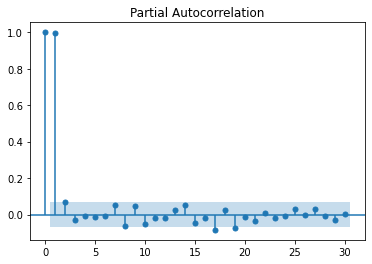

In [35]:
plot_pacf(aapl['adjusted_close'], lags = 30);

The PACF plot above shows that lag_1 has by far the highest partial autocorrelation with adjusted_close. All of the other lags under 30 days fall into or very close to the blue shaded area, meaning that they are likely not statistically signifigant.